# **Covid-19 (Week 2) - Notebook**

**Outline**

This Kaggle challenge aims to help generate tools for forecasting confirmed infections and fatalities and indentifying any factors that between the time period April 1 to April 30 by region for the COVID-19 outbreak. Inclusive within this challenge is also the identification of factors that influence the transmission of the virus. 

There are two main components to this challange:-
*     1 - COVID-19 Forecasting Challenge *(The forecasting of confirmed infections and fatalities)*
*     2 - COVID-19 Data Challenge *(Publication of new datasets seen to be useful in understanding the outbreak)*

Data provided for this challenge is sourced from Center for Systems Science and Engineering at John Hopkins University. 

__________________________________________________________________________________

**Background Research**

Background research for widely used modelling methods for forecasting infection and fatality cases outlines 3 main determinisitic modelling approaches. 


 (1) SIS - Model in which immunity is not confirmed. Infected individual return to the S state<br /> 
 
 (2,3) SIR - Model in which immunity is confirmed. Infected individuals go to the R state<br /> 
   > (2) SIR without vital dynamics - does not include births and deaths etc.<br /> 
     (3) SIR with vital dynamics - does include births and deaths (usually for longer period epidemics)  <br />


(S = Susceptible to being infected but not yet infected)<br /> 
(I = No. Infected individuals)<br /> 
(R = No, of people recovered and immune)<br /> 


*Hethcote H.W. (1989) Three Basic Epidemiological Models. In: Levin S.A., Hallam T.G., Gross L.J. (eds) Applied Mathematical Ecology. Biomathematics, vol 18. Springer, Berlin, Heidelberg*

It's widely reported that there are cases recovering from the infection which indicates the SIR model for further consideration for this challenge. 

The transition relationship between the states of the model typically forms as ( S --> I --> R), these state changes occur over time and are generally described with ordinary differential equations. The rate at which the state changes occur are described by beta and gamma. Where beta is the rate at which infection occurs through a given population and gamma is the rate at which the infected amount recover. 

The figure below outlines this relationship in a theoretical framework. 

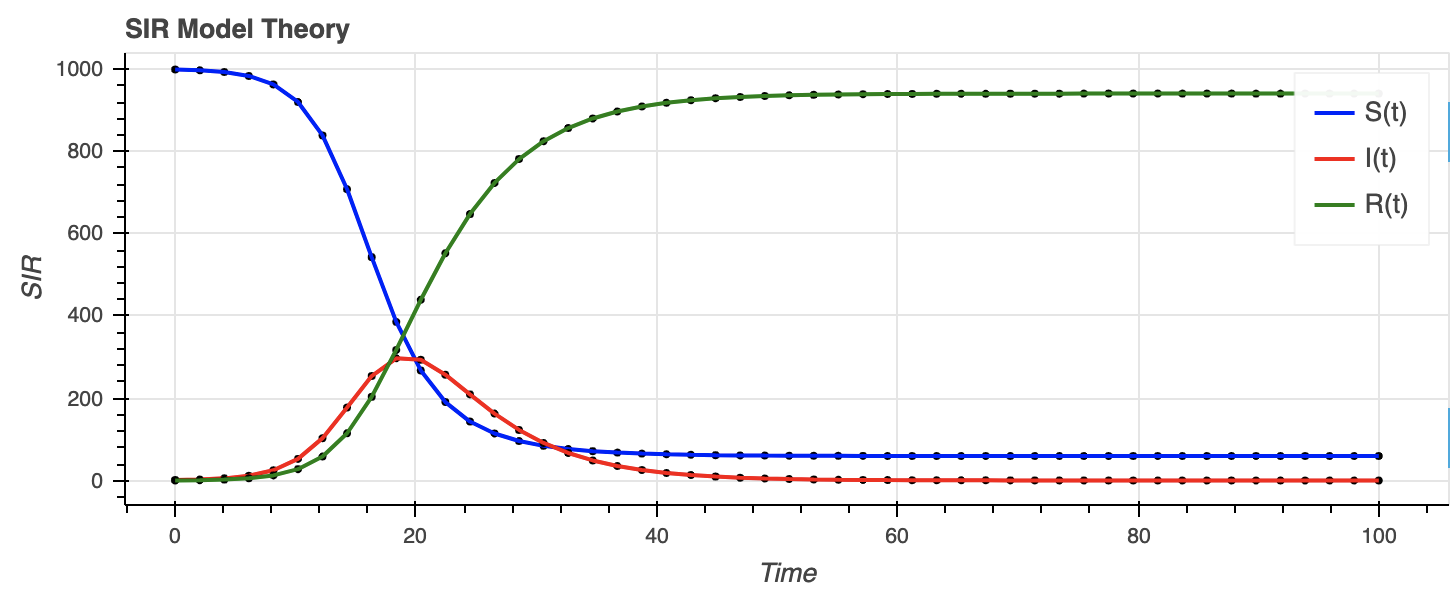

<br />



# **1 - Data Exploration**

We will start to investigate the training data (train.csv) to begin to understand how we can work with it. 

Firstly, we will import the (.csv) file into a dataframe and visualize the headings in the dataset.

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy import stats, optimize
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, gridplot
from bokeh.resources import INLINE
from bokeh.plotting import figure, output_file, save
from bokeh.models import ColumnDataSource, HoverTool
output_notebook(INLINE)

In [ ]:
#Show all files in dir with .csv extension
work_dir = ('../input/covid19-global-forecasting-week-2/')
filenames = []
for file in os.listdir(work_dir):
    if file.endswith(".csv"):
        filenames.append(os.path.join(work_dir, file))
filenames = sorted(filenames)
for filename in filenames:
    print(filename)

In [ ]:
Data_train = pd.read_csv("../input/covid19-global-forecasting-week-2/train.csv",parse_dates=[3],header="infer")
Data_train.columns

As the challenge is to generate forecasts for each region, we should now see how these regions are arranged in the dataset.

The headings at least give us an indication that the data is divided by country (Country_Region) and by area/state (Province_State). Firstly let's see what countries we have. 

In [ ]:
Data_train.Country_Region.unique()

The above output shows quite a high list of different countries, let's choose one country to look into further for simplicity. 

China seems like a good place to begin as this is where the virus started and is more than likely the most mature in terms of virus progression.  Let's see how many provice regions are captured for this country. 

In [ ]:
Data_train_China = Data_train[Data_train.Country_Region.str.contains('China', case=False)]
Data_train_China.Province_State.unique()

Again there's quite a few provinces captured. It's widely reported that Hubei was the province for the virus origin, so let's investigate this one for simplicity and see what the data contains. 

In [ ]:
Data_train_China_Hubei = Data_train_China[Data_train_China.Province_State.str.contains('Hubei', case=False)]
Data_train_China_Hubei

We can evidentially see the number of confirmed cases and fatalities increases cumulatively over the dataset of 70 index rows. 



When processing the data for a fit to an SIR model, we must approximate the number of people currently infected on a given day. The data provided in train.csv has aggregate confirmed cases up to the date. We have currently used an estimate of 7 days for a person being infected and consequently contagious. 

To calculate the our value we first take the backwards difference of consecutive values of the confirmed cases. 

A 3 point rolling mean is then applied to smooth the data. The rolling mean is right aligned meaning that a data point is the average of its current difference and the two previous days. This is an approximate of the number of people with the infection on a given day (the derivative of the aggregate confirmed cases). 

We then apply a rolling sum on a window of 7 days to give an approximate the number of people currently infected with the virus. Again this rolling window is right aligned to assume that the number of people infected on a given day is sum of daily new cases for that day and the previous six.

Some considerations for further work:

* It may be that a weighted smoothing function is more appropriate for approximating daily new cases.
* 
* The window of the rolling sum is attempting to approximate the function $I()$ in the SIR model, as such it should be approximating the population currently infected that are contagious. 
* 
* We may choose to scale up the approximation of I() by some function since the data used is confirmed cases and we would like an estimate of all current cases. This function may include factors specific to countries or regions based on testing and reporting policy.   


In [ ]:
Data_train_China_Hubei_grouped = Data_train_China_Hubei.groupby('Date').sum()
Data_train_China_Hubei_grouped.reset_index(inplace=True)
y=Data_train_China_Hubei_grouped.ConfirmedCases

ydiff = y.diff()
ydiff[0] = 0
y2 = ydiff.rolling(window = 3).mean()
y2[0] = ydiff[0]
y2[1] = ydiff[1]

y3 = y2.rolling(window = 7).sum()
y3[0:6] = y2[0:6]

#Plotting
_tools_to_show = 'box_zoom,pan,save,hover,reset,wheel_zoom'
p1 = figure(plot_width = 850, plot_height = 400, x_axis_label = 'Date', y_axis_label = "No. of Infections", 
            title="Hubei Infections", tools=_tools_to_show, x_axis_type='datetime')

p1.circle(x=Data_train_China_Hubei_grouped.Date, y=Data_train_China_Hubei_grouped.ConfirmedCases, color="black",size=2)
p1.line(x=Data_train_China_Hubei_grouped.Date, y=Data_train_China_Hubei_grouped.ConfirmedCases, color="red",line_width=1, 
        legend_label="Cumulative agrregate of confirmed cases")


p1.circle(x=Data_train_China_Hubei_grouped.Date, y=y3, color="black",size=2)
p1.line(x=Data_train_China_Hubei_grouped.Date, y=y3, color="blue",line_width=1, 
        legend_label="Approximation of confirmed cases")

hover = p1.select(dict(type=HoverTool))
hover.tooltips = [("Time", "@x"),  ("Value", "@y"),]
show(p1,notebook_handle=True)

In [ ]:
#x = Data_train_China_Hubei_grouped.Date
#x1 = np.linspace(0, Data_train_China_Hubei_grouped.Id.size, Data_train_China_Hubei_grouped.Id.size)
#y = Data_train_China_Hubei_grouped.ConfirmedCases

#print(y.diff())


Normal distribution fit based on 7 day rolling window cumulative average of $i$. 

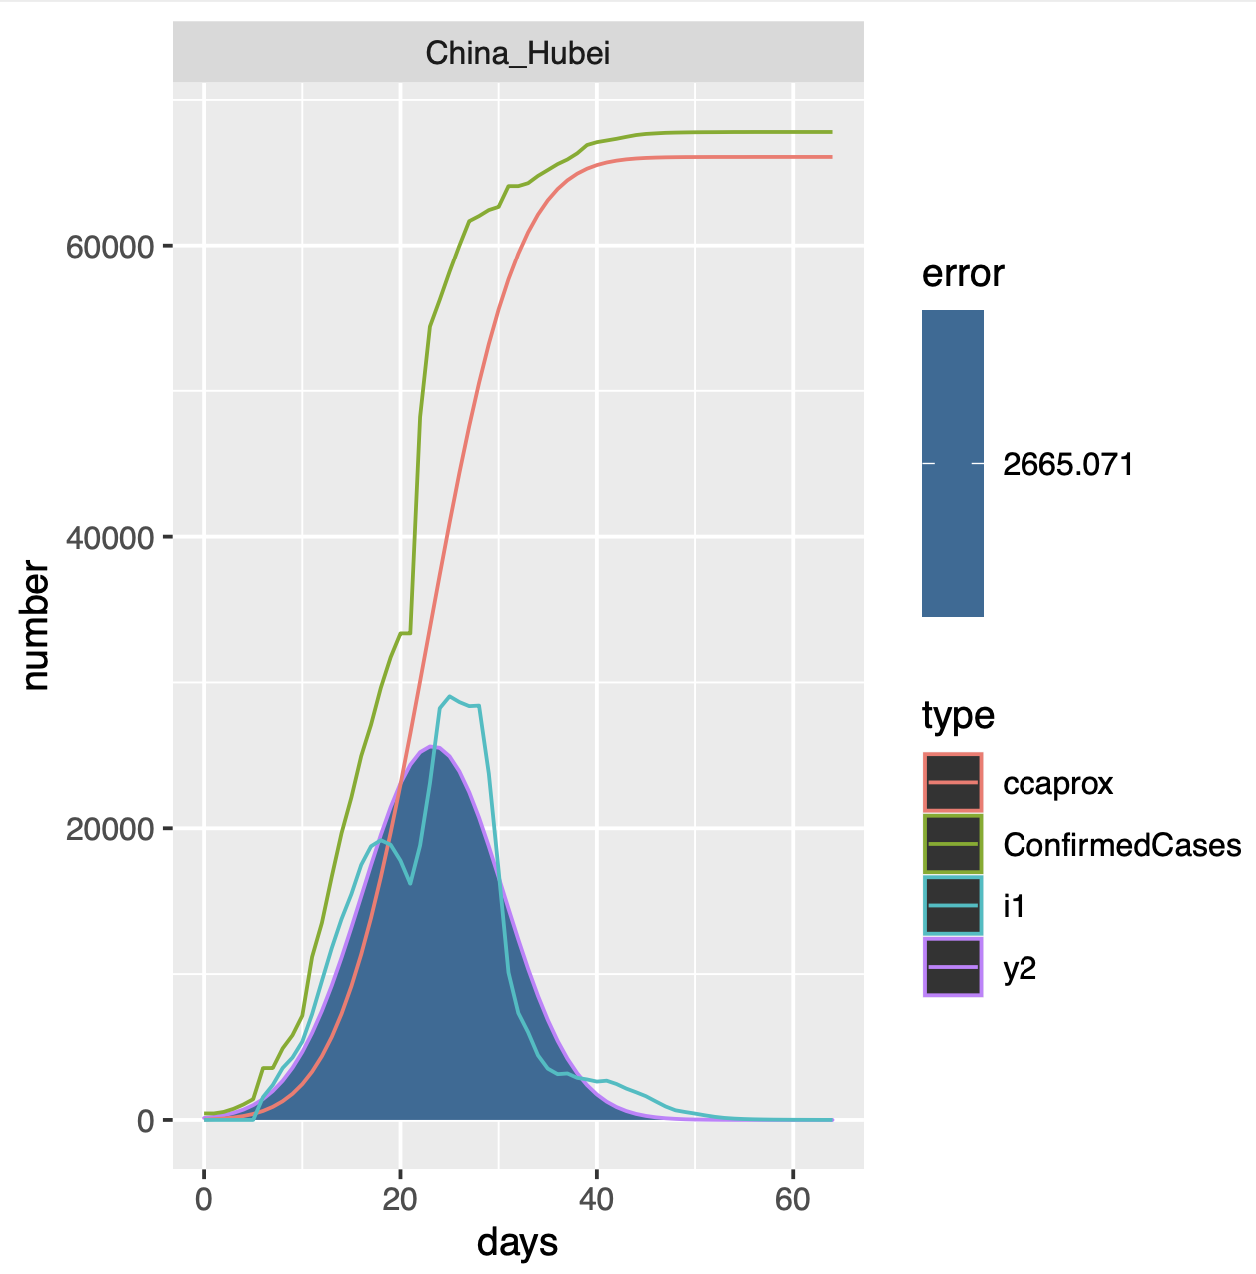

 4th order polynomial fit based on 7 day rolling window cumulative average of $i$. 

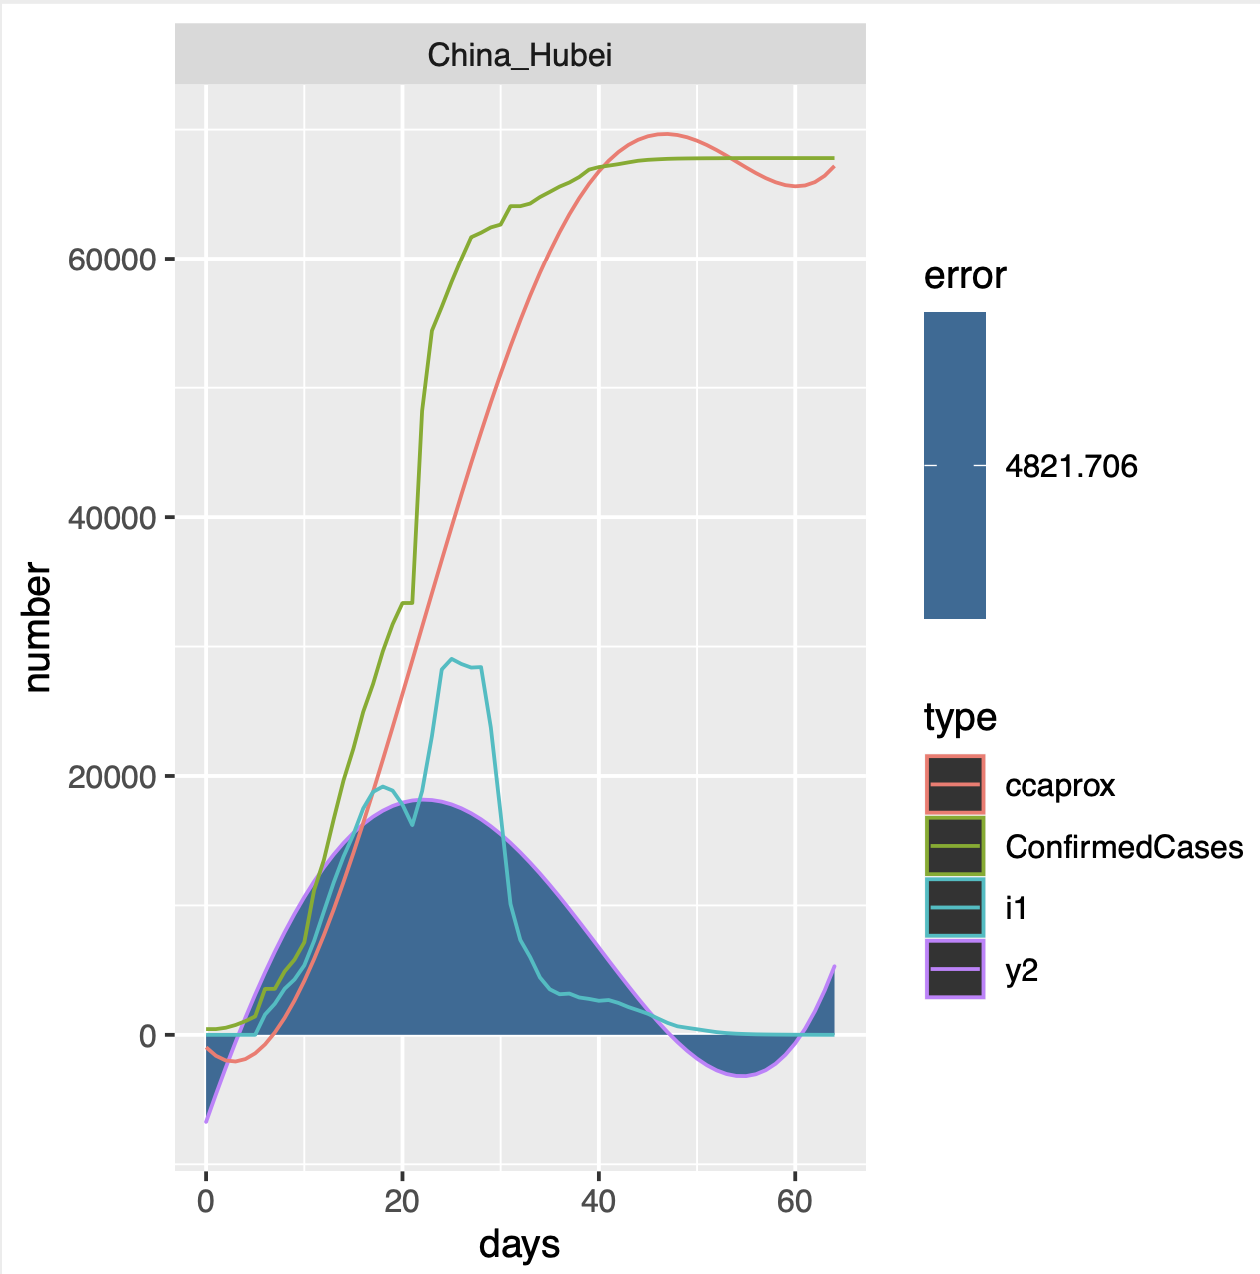

In [ ]:
sub = pd.read_csv("../input/covid19-global-forecasting-week-2/submission.csv")
sub.to_csv('submission.csv', index=False)